In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/frenchenglish/_about.txt
/kaggle/input/frenchenglish/fra.txt


In [165]:
import os
import re
import unicodedata
import matplotlib.ticker as ticker

import tensorflow as tf

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.model_selection import train_test_split

import time
import math

from transformers import AutoTokenizer

In [96]:
data_path = '/kaggle/input/frenchenglish/fra.txt'

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
inputs = []
targets = []
num_samples = 10000  # Number of samples to train on.
for line in lines[:- 1]:

    input,target,_= line.split('\t')
    inputs.append(input)
    targets.append(target)

In [97]:
print(len(inputs),len(targets))
print(inputs[:5])
print(targets[:5])

177210 177210
['Go.', 'Hi.', 'Hi.', 'Run!', 'Run!']
['Va !', 'Salut !', 'Salut.', 'Cours\u202f!', 'Courez\u202f!']


In [98]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def replace_phrase(text):
        text = unicode_to_ascii(text.lower().strip())
        text = text.lower()
        text = re.sub(r"there's", "there is", str(text))
        text = re.sub(r"i'm", "i am",  str(text))
        text = re.sub(r"he's", "he is",  str(text))
        text = re.sub(r"she's", "she is",  str(text))
        text = re.sub(r"it's", "it is",  str(text))
        text = re.sub(r"that's", "that is",  str(text))
        text = re.sub(r"what's", "that is",  str(text))
        text = re.sub(r"where's", "where is",  str(text))
        text = re.sub(r"how's", "how is",  str(text))
        text = re.sub(r"\'ll", " will",  str(text))
        text = re.sub(r"\'ve", " have",  str(text))
        text = re.sub(r"\'re", " are",  str(text))
        text = re.sub(r"\'d", " would",  str(text))
        text = re.sub(r"\'re", " are",  str(text))
        text = re.sub(r"won't", "will not",  str(text))
        text = re.sub(r"can't", "cannot",  str(text))
        text = re.sub(r"n't", " not",  str(text))
        text = re.sub(r"n'", "ng",  str(text))
        text = re.sub(r"'bout", "about",  str(text))
        text = re.sub(r"'til", "until",  str(text))
        text = re.sub(r'[" "]+', " ", str(text))
        text = re.sub(r"([?.!,¿])", r" \1 ", text)
        text = re.sub(r"[^a-zA-Z؀-ۿ?.!,¿]+", " ", str(text))
        text = re.sub(r'\b(\w+)\'s\b', r'\1 is', str(text)) #word's => word is
        text = re.sub(r'\b(\w+)\'t\b', r'\1 not', str(text)) #word't => word not
        text = text.strip()
        text = '<start> %s <end>'%text
        
        return text

In [100]:
pre_inputs = [ replace_phrase(l) for l in inputs]
pre_targets = [ replace_phrase(l) for l in targets]

print(inputs[500])
print(targets[500])


print(pre_inputs[500])
print(pre_targets[500])

Call home!
Appelle à la maison !
<start> call home ! <end>
<start> appelle a la maison ! <end>


In [102]:
len(pre_inputs)

177210

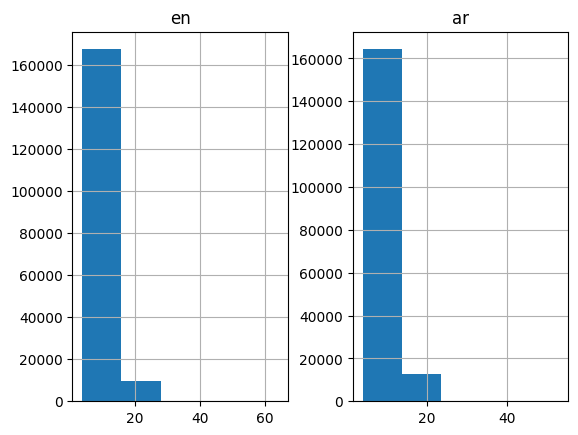

In [103]:
en_count = []
ar_count = []

for sent in pre_inputs:
    ar_count.append(len(sent.split()))
for sent in pre_targets:
    en_count.append(len(sent.split()))

graph_df= pd.DataFrame()
graph_df['en']=en_count
graph_df['ar']=ar_count

import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [106]:
inp_lang=pre_inputs[:12000]
targ_lang=pre_targets[:12000]

In [107]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [108]:
input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
target_tensor, targ_lang_tokenizer = tokenize(targ_lang)


In [109]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [110]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

9600 9600 2400 2400


In [111]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [113]:
print ("Input Language; index to word mapping")
convert(inp_lang_tokenizer, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang_tokenizer, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
49 ----> how
103 ----> nice
17 ----> !
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
115 ----> comme
16 ----> c
6 ----> est
678 ----> chouette
5 ----> !
2 ----> <end>


In [115]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [116]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 8]), TensorShape([64, 15]))

In [118]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(vocab_inp_size, units, input_length=max_length_inp, mask_zero=True))
model.add(tf.keras.layers.LSTM(units, dropout=0.3, recurrent_dropout=0.3))
model.add(tf.keras.layers.RepeatVector(max_length_targ))
model.add(tf.keras.layers.LSTM(units, return_sequences=True))
model.add(tf.keras.layers.Dense(vocab_tar_size, activation='softmax'))
rms = tf.keras.optimizers.RMSprop(lr=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 8, 1024)           2489344   
                                                                 
 lstm_2 (LSTM)               (None, 1024)              8392704   
                                                                 
 repeat_vector_1 (RepeatVec  (None, 15, 1024)          0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 15, 1024)          8392704   
                                                                 
 dense_153 (Dense)           (None, 15, 4391)          4500775   
                                                                 
Total params: 23775527 (90.70 MB)
Trainable params: 23775527 (90.70 MB)
Non-trainable params: 0 (0.00 Byte)
___________

In [119]:
target_tensor_train.shape

(9600, 15)

In [120]:
filename = '/kaggle/working/LSTM/LSTM.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(input_tensor_train, target_tensor_train.reshape(target_tensor_train.shape[0], target_tensor_train.shape[1], 1),
                    epochs=10, batch_size=128,callbacks=[checkpoint], validation_data=(input_tensor_val,target_tensor_val),
                    verbose=1)

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 2.5233
Epoch 1: val_loss improved from inf to 1.81239, saving model to /kaggle/working/LSTM/LSTM.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 17s 144ms/step - loss: 2.5233 - val_loss: 1.8124
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 1.7342
Epoch 2: val_loss improved from 1.81239 to 1.72964, saving model to /kaggle/working/LSTM/LSTM.h5
75/75 [==============================] - 7s 99ms/step - loss: 1.7342 - val_loss: 1.7296
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 1.6356
Epoch 3: val_loss improved from 1.72964 to 1.64177, saving model to /kaggle/working/LSTM/LSTM.h5
75/75 [==============================] - 8s 101ms/step - loss: 1.6356 - val_loss: 1.6418
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 1.4990
Epoch 4: val_loss improved from 1.64177 to 1.54520, saving model to /kaggle/working/LSTM/LSTM.h5
75/75 [==============================] - 7s 97ms/step - loss: 1.4990 - val_loss: 1.5452
Epoch 5/10
75/75 [==============================] - ETA: 0s - loss: 1.3840
Epoch 5: val_loss improved from 1.54520 to 1.48015, sa

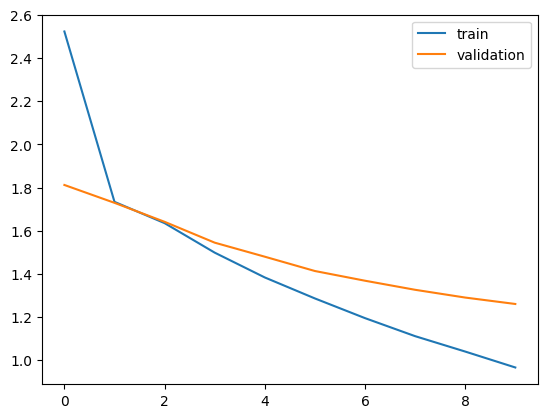

In [121]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [122]:
model = tf.keras.models.load_model('/kaggle/working/LSTM/LSTM.h5')
preds = model.predict(input_tensor_val.reshape((input_tensor_val.shape[0],input_tensor_val.shape[1])))

75/75 [==============================] - 2s 13ms/step


In [127]:
def gru(units):

    return tf.keras.layers.GRU(units,
                                return_sequences=True,
                                return_state=True,
                                recurrent_activation='sigmoid',
                                recurrent_initializer='glorot_uniform')

In [130]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [131]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 8, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [133]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [134]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 8, 1)


In [135]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)

        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [136]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4391)


In [137]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [138]:
checkpoint_dir = '/kaggle/working/'
checkpoint_prefix = os.path.join(checkpoint_dir, "h5")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [141]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [142]:
from tqdm import tqdm
EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

 10%|█         | 1/10 [00:38<05:47, 38.59s/it]

Epoch 1 Loss 1.6545
Time taken for 1 epoch 38.59268617630005 sec



 20%|██        | 2/10 [00:51<03:06, 23.29s/it]

Epoch 2 Loss 1.1770
Time taken for 1 epoch 12.577433109283447 sec



 30%|███       | 3/10 [01:03<02:08, 18.35s/it]

Epoch 3 Loss 0.9615
Time taken for 1 epoch 12.464484930038452 sec



 40%|████      | 4/10 [01:15<01:35, 15.88s/it]

Epoch 4 Loss 0.7958
Time taken for 1 epoch 12.088610649108887 sec



 50%|█████     | 5/10 [01:27<01:11, 14.29s/it]

Epoch 5 Loss 0.6559
Time taken for 1 epoch 11.46717643737793 sec



 60%|██████    | 6/10 [01:38<00:53, 13.43s/it]

Epoch 6 Loss 0.5393
Time taken for 1 epoch 11.755819082260132 sec



 70%|███████   | 7/10 [01:50<00:38, 12.76s/it]

Epoch 7 Loss 0.4361
Time taken for 1 epoch 11.394020318984985 sec



 80%|████████  | 8/10 [02:02<00:24, 12.45s/it]

Epoch 8 Loss 0.3538
Time taken for 1 epoch 11.783916473388672 sec



 90%|█████████ | 9/10 [02:13<00:12, 12.14s/it]

Epoch 9 Loss 0.2894
Time taken for 1 epoch 11.454389333724976 sec



100%|██████████| 10/10 [02:25<00:00, 14.54s/it]

Epoch 10 Loss 0.2415
Time taken for 1 epoch 11.823811054229736 sec



In [166]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = replace_phrase(sentence)

    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

        return result, sentence, attention_plot

In [167]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [168]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [169]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> go . <end>
Predicted translation: va 


/tmp/ipykernel_42/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_42/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


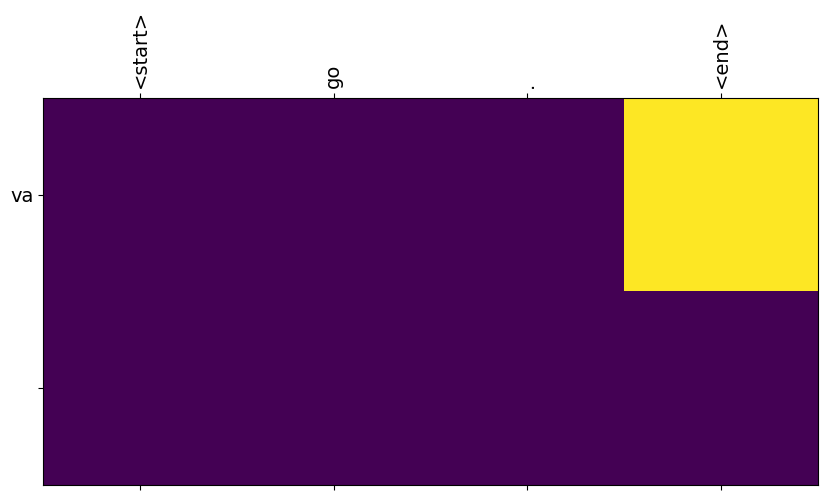

In [171]:
translate(u'Go.')

Input: <start> let s ask . <end>
Predicted translation: demandons 


/tmp/ipykernel_42/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_42/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


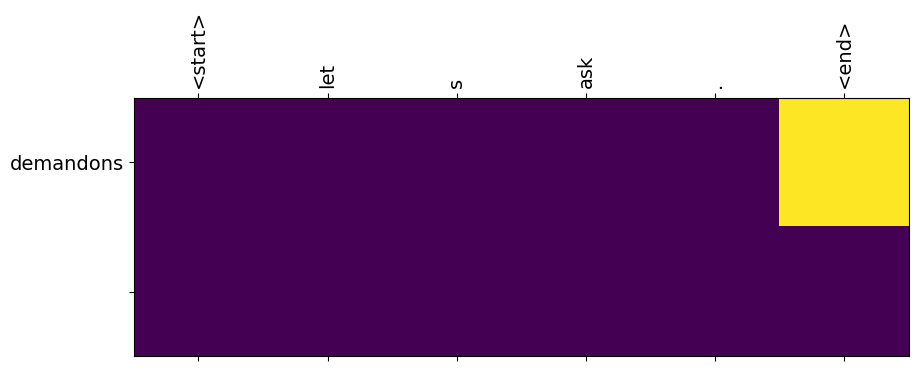

In [177]:
translate(u'Let\'s ask.')

In [184]:
train_examples = tf.data.Dataset.from_tensor_slices((inputs[:15000], targets[:15000]))

In [200]:
inputs[0]

'Go.'

In [306]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en, fr in train_examples), target_vocab_size=2**13)

tokenizer_fr = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (fr.numpy() for en, fr in train_examples), target_vocab_size=2**13)

In [307]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [3713, 3743, 3726, 3739, 3744, 930, 22, 3743, 3661, 8, 360, 3675]
The original string: Transformer is awesome.


In [308]:
for ts in tokenized_string:
      print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

3713 ----> T
3743 ----> r
3726 ----> a
3739 ----> n
3744 ----> s
930 ----> for
22 ----> me
3743 ----> r
3661 ---->  
8 ----> is 
360 ----> awesome
3675 ----> .


In [309]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [310]:
def encode(lang1, lang2):
    lang2 = [tokenizer_fr.vocab_size] + tokenizer_fr.encode(
      lang2.numpy()) + [tokenizer_fr.vocab_size+1]

    lang1 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang1.numpy()) + [tokenizer_en.vocab_size+1]

    return lang2, lang1

In [311]:
def tf_encode(en,fr):
    result_en,result_fr = tf.py_function(encode, [en, fr], [tf.int64, tf.int64])
    result_fr.set_shape([None])
    result_en.set_shape([None])

    return  result_en,result_fr

In [312]:
MAX_LENGTH = 40

In [313]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [314]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


#val_dataset = val_examples.map(tf_encode)
#val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [315]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [316]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


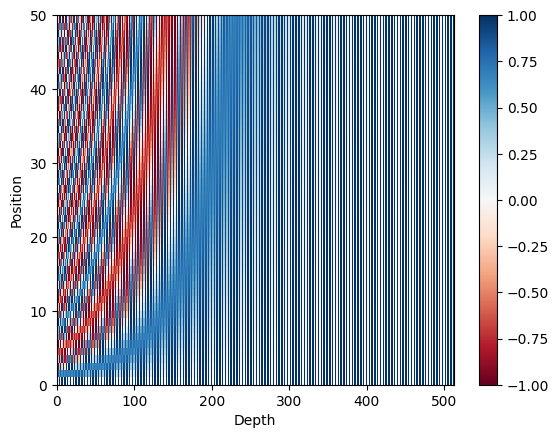

In [317]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [318]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [319]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [320]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [321]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [322]:
def scaled_dot_product_attention(q, k, v, mask):

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [323]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [324]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [325]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [326]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [327]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [328]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [329]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [330]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [331]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [332]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [333]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [334]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
               look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [335]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [336]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                   maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
          x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [337]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62)


In [338]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                   maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
               look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

                attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
                attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [339]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 1]))

In [340]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                   target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
               look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [341]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [342]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [343]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)  # Convert d_model to float32
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        dtype = self.d_model.dtype
        step = tf.cast(step, dtype)  # Convert step to the same data type as d_model
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [344]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

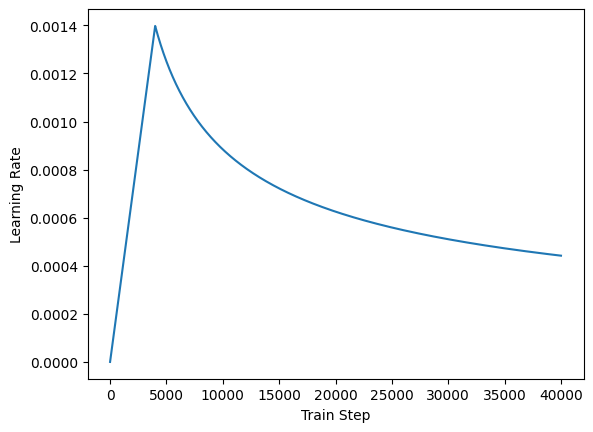

In [345]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [346]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [347]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [348]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [349]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [350]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [351]:
checkpoint_path = "/kaggle/working/"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [352]:
EPOCHS = 10

In [353]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [354]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> arabic, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

ValueError: in user code:

    File "/tmp/ipykernel_42/708063167.py", line 14, in train_step  *
        predictions, _ = transformer(inp, tar_inp,
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file4orm99jf.py", line 11, in tf__call
        (dec_output, attention_weights) = ag__.converted_call(ag__.ld(self).decoder, (ag__.ld(tar), ag__.ld(enc_output), ag__.ld(training), ag__.ld(look_ahead_mask), ag__.ld(dec_padding_mask)), None, fscope)
    File "/tmp/__autograph_generated_filehrb79wai.py", line 35, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(range), (ag__.ld(self).num_layers,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
    File "/tmp/__autograph_generated_filehrb79wai.py", line 29, in loop_body
        (x, block1, block2) = ag__.converted_call(ag__.ld(self).dec_layers[ag__.ld(i)], (ag__.ld(x), ag__.ld(enc_output), ag__.ld(training), ag__.ld(look_ahead_mask), ag__.ld(padding_mask)), None, fscope)
    File "/tmp/__autograph_generated_fileu4ao0hhn.py", line 13, in tf__call
        (attn2, attn_weights_block2) = ag__.converted_call(ag__.ld(self).mha2, (ag__.ld(enc_output), ag__.ld(enc_output), ag__.ld(out1), ag__.ld(padding_mask)), None, fscope)
    File "/tmp/__autograph_generated_filenp7qkyvi.py", line 12, in tf__call
        k = ag__.converted_call(ag__.ld(self).wk, (ag__.ld(k),), None, fscope)

    ValueError: Exception encountered when calling layer 'transformer_7' (type Transformer).
    
    in user code:
    
        File "/tmp/ipykernel_42/4170104401.py", line 20, in call  *
            dec_output, attention_weights = self.decoder(
        File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_filehrb79wai.py", line 35, in tf__call
            ag__.for_stmt(ag__.converted_call(ag__.ld(range), (ag__.ld(self).num_layers,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        File "/tmp/__autograph_generated_filehrb79wai.py", line 29, in loop_body
            (x, block1, block2) = ag__.converted_call(ag__.ld(self).dec_layers[ag__.ld(i)], (ag__.ld(x), ag__.ld(enc_output), ag__.ld(training), ag__.ld(look_ahead_mask), ag__.ld(padding_mask)), None, fscope)
        File "/tmp/__autograph_generated_fileu4ao0hhn.py", line 13, in tf__call
            (attn2, attn_weights_block2) = ag__.converted_call(ag__.ld(self).mha2, (ag__.ld(enc_output), ag__.ld(enc_output), ag__.ld(out1), ag__.ld(padding_mask)), None, fscope)
        File "/tmp/__autograph_generated_filenp7qkyvi.py", line 12, in tf__call
            k = ag__.converted_call(ag__.ld(self).wk, (ag__.ld(k),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'decoder_12' (type Decoder).
        
        in user code:
        
            File "/tmp/ipykernel_42/522196769.py", line 29, in call  *
                x, block1, block2 = self.dec_layers[i](x, enc_output, training,
            File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/tmp/__autograph_generated_fileu4ao0hhn.py", line 13, in tf__call
                (attn2, attn_weights_block2) = ag__.converted_call(ag__.ld(self).mha2, (ag__.ld(enc_output), ag__.ld(enc_output), ag__.ld(out1), ag__.ld(padding_mask)), None, fscope)
            File "/tmp/__autograph_generated_filenp7qkyvi.py", line 12, in tf__call
                k = ag__.converted_call(ag__.ld(self).wk, (ag__.ld(k),), None, fscope)
        
            ValueError: Exception encountered when calling layer 'decoder_layer_32' (type DecoderLayer).
            
            in user code:
            
                File "/tmp/ipykernel_42/95058256.py", line 27, in call  *
                    attn2, attn_weights_block2 = self.mha2(
                File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/tmp/__autograph_generated_filenp7qkyvi.py", line 12, in tf__call
                    k = ag__.converted_call(ag__.ld(self).wk, (ag__.ld(k),), None, fscope)
            
                ValueError: Exception encountered when calling layer 'multi_head_attention_105' (type MultiHeadAttention).
                
                in user code:
                
                    File "/tmp/ipykernel_42/3231277781.py", line 25, in call  *
                        k = self.wk(k)  # (batch_size, seq_len, d_model)
                    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                        raise e.with_traceback(filtered_tb) from None
                    File "/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 148, in build
                        raise ValueError(
                
                    ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)
                
                
                Call arguments received by layer 'multi_head_attention_105' (type MultiHeadAttention):
                  • v=tf.Tensor(shape=(None, None), dtype=int64)
                  • k=tf.Tensor(shape=(None, None), dtype=int64)
                  • q=tf.Tensor(shape=(None, None, 128), dtype=float32)
                  • mask=tf.Tensor(shape=(None, 1, 1, None), dtype=float32)
            
            
            Call arguments received by layer 'decoder_layer_32' (type DecoderLayer):
              • x=tf.Tensor(shape=(None, None, 128), dtype=float32)
              • enc_output=tf.Tensor(shape=(None, None), dtype=int64)
              • training=True
              • look_ahead_mask=tf.Tensor(shape=(None, 1, None, None), dtype=float32)
              • padding_mask=tf.Tensor(shape=(None, 1, 1, None), dtype=float32)
        
        
        Call arguments received by layer 'decoder_12' (type Decoder):
          • x=tf.Tensor(shape=(None, None), dtype=int64)
          • enc_output=tf.Tensor(shape=(None, None), dtype=int64)
          • training=True
          • look_ahead_mask=tf.Tensor(shape=(None, 1, None, None), dtype=float32)
          • padding_mask=tf.Tensor(shape=(None, 1, 1, None), dtype=float32)
    
    
    Call arguments received by layer 'transformer_7' (type Transformer):
      • inp=tf.Tensor(shape=(None, None), dtype=int64)
      • tar=tf.Tensor(shape=(None, None), dtype=int64)
      • training=True
      • enc_padding_mask=tf.Tensor(shape=(None, 1, 1, None), dtype=float32)
      • look_ahead_mask=tf.Tensor(shape=(None, 1, None, None), dtype=float32)
      • dec_padding_mask=tf.Tensor(shape=(None, 1, 1, None), dtype=float32)
